# VAE

In [1]:
from model import VAE

import tensorflow as tf
import keras as K
import numpy as np
import os

### Data Preprocessing

In [2]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

### Training the VAE

In [7]:
vae = VAE(image_size=28, channels=1, latent_dim=2)
vae.compile(optimizer=K.optimizers.Adam(learning_rate=1e-5))
callbacks = vae.get_callbacks(log_dir="logs", patience=3)
vae.fit(mnist_digits, epochs=30, batch_size=256, callbacks=callbacks)

Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - kl_loss: 0.0241 - loss: 539.5704 - reconstruction_loss: 539.5463
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - kl_loss: 3.5900 - loss: 520.4803 - reconstruction_loss: 516.8903
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 30.3720 - loss: 422.4919 - reconstruction_loss: 392.1197
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 34.7852 - loss: 311.7401 - reconstruction_loss: 276.9549
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 25.1586 - loss: 269.3354 - reconstruction_loss: 244.1767
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 18.9482 - loss: 247.8726 - reconstruction_loss: 228.9246
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 15.0213 - loss: 235.3907 - reconstruction_loss: 220.3694
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - kl_loss: 12.4029 - loss: 227.3227 - reconstruction_loss: 214.9197
Epoch 9/30
274/274 ━━━━━━━━━━━━━━━

In [8]:
for metric in vae.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 195.83010864257812
reconstruction_loss: 189.9564971923828
kl_loss: 5.87361478805542


Esto da diferente estoy usando un device M3 (a través de Metal Performance Shaders) que en tiene un comportamiento numérico diferente a CUDA. De hecho tuve usar un clip en el kl_loss para evitar explosiones numéricas.

In [9]:
# Save
os.makedirs("./weights", exist_ok=True)
vae.encoder.save("./weights/encoder.keras")
vae.decoder.save("./weights/decoder.keras")

### View Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


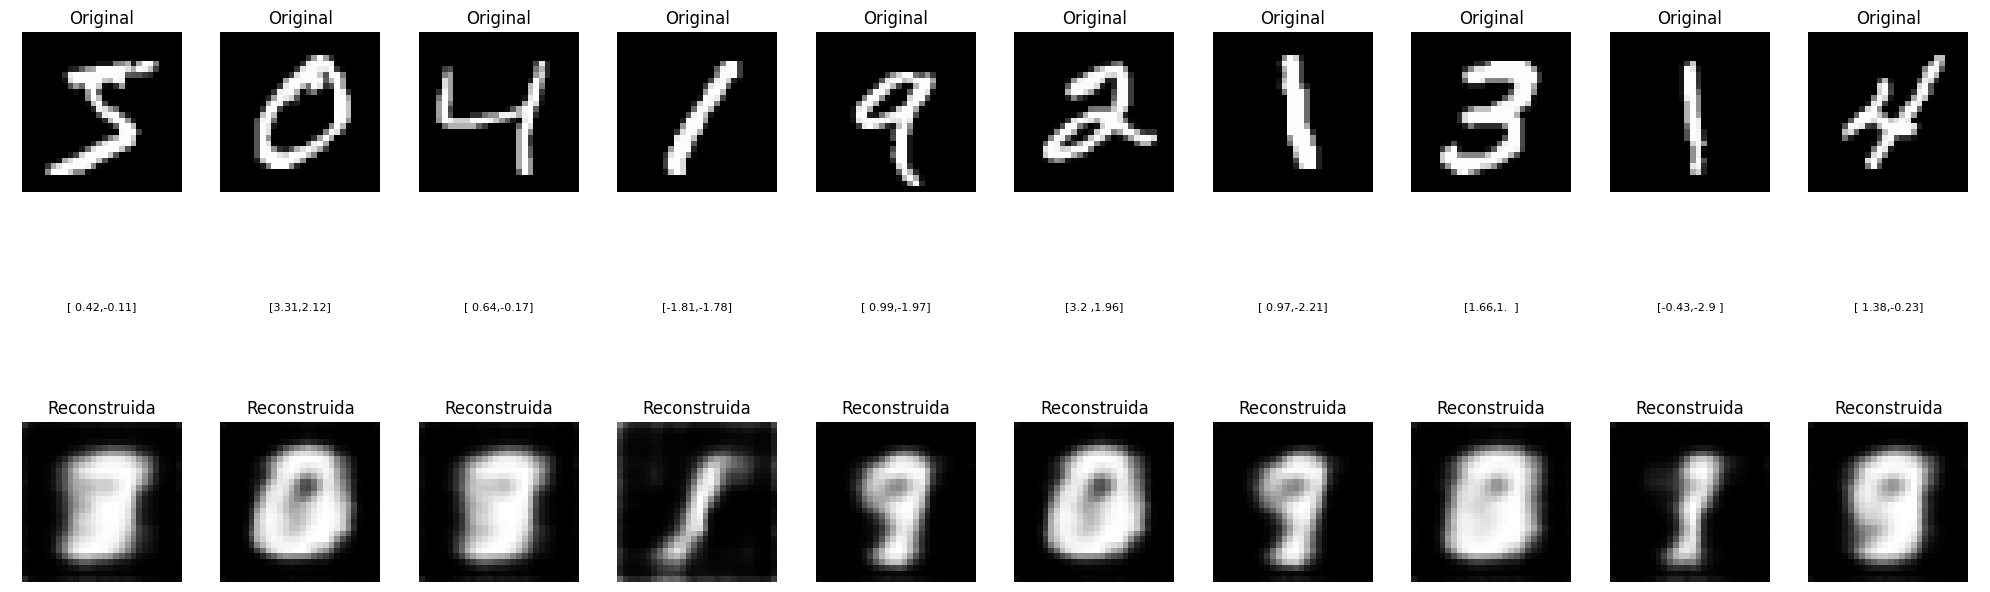

In [11]:
import matplotlib.pyplot as plt

n = 10
example_images = mnist_digits[:n]

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae.encoder.predict(example_images)
predictions = vae.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Vector latente z (como texto en una celda)
    ax = plt.subplot(3, n, i + 1 + n)
    ax.axis("off")
    z_text = np.array2string(z[i], precision=2, separator=",")
    ax.text(0.5, 0.5, z_text, ha="center", va="center", fontsize=8)

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()


## CelebA Dataset

In [24]:
# Import TFDS to download CelebA

import tensorflow_datasets as tfds

# Automatic download
#celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
#celeb_a_builder.download_and_prepare()

# If downloading manually
celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
celeb_a_builder.download_and_prepare(download_config=tfds.download.DownloadConfig(manual_dir="../datasets/"))

In [25]:
# Cargar splits de train y test
celeb_a_train = celeb_a_builder.as_dataset(split='train', shuffle_files=True)
celeb_a_test = celeb_a_builder.as_dataset(split='test', shuffle_files=True)

In [26]:
def preprocess_celeba(example):
    image = tf.cast(example['image'], tf.float32) / 255.0
    image = tf.image.resize(image, [64, 64])
    return image

batch_size = 256

celeb_a_train_batched = celeb_a_train.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
celeb_a_test_batched = celeb_a_test.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [30]:

vae2 = VAE(image_size=64, channels=3, latent_dim=256)

# Debemos reemplazar el decoder para que produzca imágenes de 64x64x3
latent_inputs = K.layers.Input(shape=(vae2.latent_dim,))
x = K.layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = K.layers.Reshape((8, 8, 64))(x)
x = K.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # 16x16
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 32x32
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 64x64
decoder_outputs = K.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
vae2.decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")

vae2.compile(optimizer=K.optimizers.Adam(learning_rate=1e-5))
callbacks2 = vae2.get_callbacks(log_dir="logs", patience=3)
vae2.fit(celeb_a_train_batched, epochs=50, callbacks=callbacks2)

Epoch 1/50


/Users/roicort/GitHub/VAE-VQ-VAE/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['dense_14/kernel', 'dense_14/bias', 'conv2d_transpose_21/kernel', 'conv2d_transpose_21/bias', 'conv2d_transpose_22/kernel', 'conv2d_transpose_22/bias', 'conv2d_transpose_23/kernel', 'conv2d_transpose_23/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


636/636 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - kl_loss: 1.9606 - loss: 2811.7034 - reconstruction_loss: 2809.7458
Epoch 2/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - kl_loss: 1.9606 - loss: 2811.7034 - reconstruction_loss: 2809.7458
Epoch 2/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - kl_loss: 16.6403 - loss: 2639.3767 - reconstruction_loss: 2622.7378
Epoch 3/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - kl_loss: 16.6403 - loss: 2639.3767 - reconstruction_loss: 2622.7378
Epoch 3/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - kl_loss: 15.4128 - loss: 2586.0579 - reconstruction_loss: 2570.6436
Epoch 4/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - kl_loss: 15.4128 - loss: 2586.0579 - reconstruction_loss: 2570.6436
Epoch 4/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - kl_loss: 18.1564 - loss: 2557.8005 - reconstruction_loss: 2539.6426
Epoch 5/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - kl_loss: 18.1564 - loss: 2557.8005 - reconstruction_loss: 2539.6426
Epoch 5/50
636/636 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


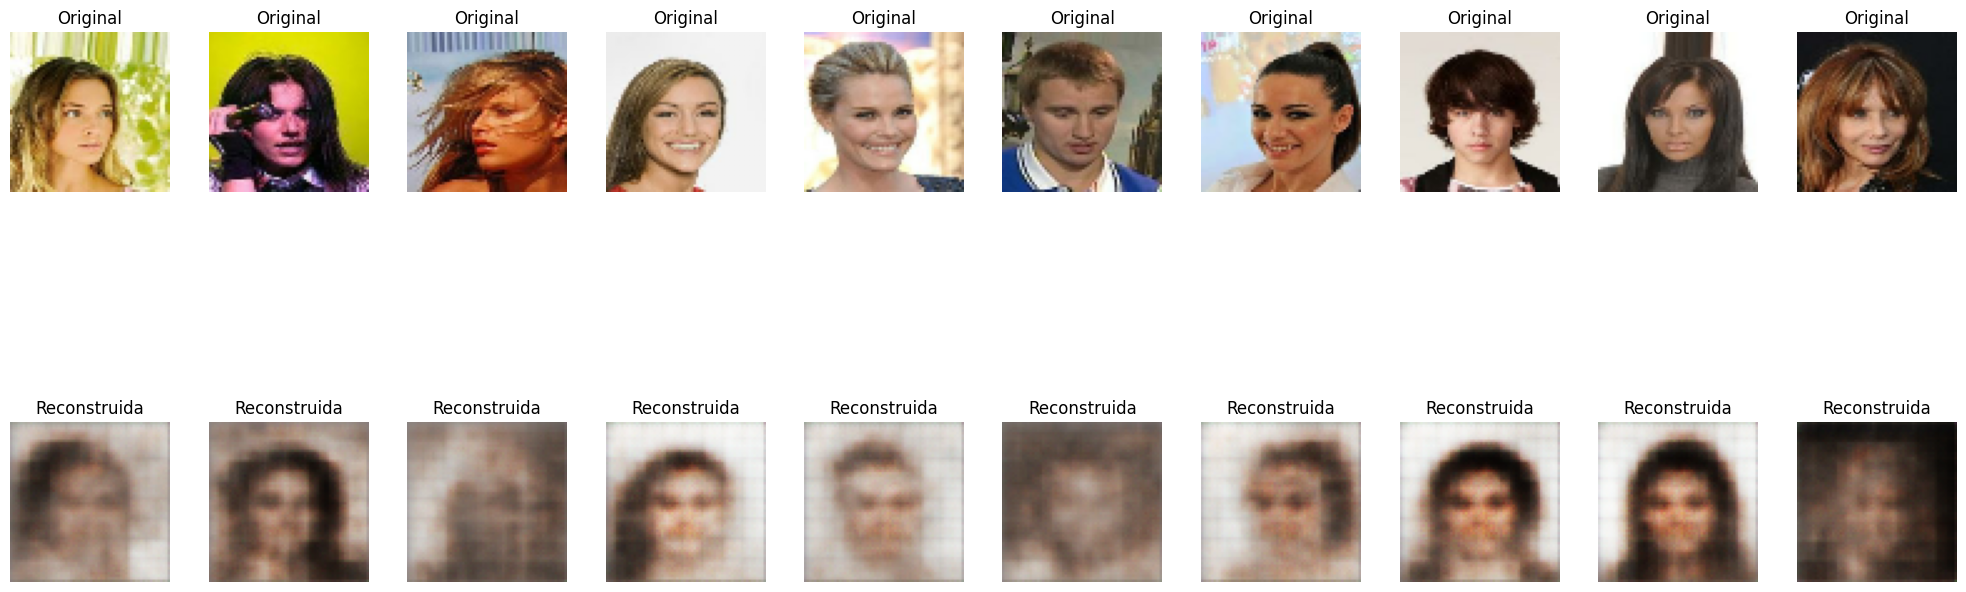

In [32]:
import matplotlib.pyplot as plt

n = 10
images_list = []
for batch in celeb_a_test_batched:
    for img in batch:
        images_list.append(img.numpy())
        if len(images_list) == n:
            break
    if len(images_list) == n:
        break
images = np.stack(images_list)  # shape (n, 64, 64, 3)

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae2.encoder.predict(images)
predictions = vae2.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i].squeeze())
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze())
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()
